# Policy Gradients
https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/5-1-A-PG/

 Q learning, Deep Q Network都是学习奖惩值，根据自己认为的高价值选行为；如果在无穷多的动作中计算价值吃不消。
 
 Policy Gradients 直接输出行为，可以在一个连续区间内挑选动作。没有误差反向传递，但有反向传递，为了让这次被选中的行为更有可能在下次发生。使用reward奖惩确定这个行为是否应当被增加选中的概率。

Policy gradients核心思想举例：设有2个action，假如这次的观测信息让神经网络选择了 action 1 ,  action 1 随之想要进行反向传递, 使 action 1 下次被多选一点, 这时, 奖惩信息也来了, 告诉我们这是好行为, 那我们就在这次反向传递的时候加大力度, 让它下次被多选的幅度更猛烈! 假如观测的信息通过神经网络分析, 选出了 action 2 , 我们直接进行反向传递, 使之下次被选的可能性增加, 但是奖惩信息却告诉我们,  action 2 是不好的, 那我们的动作可能性增加的幅度随之被减低. 这样就能靠奖励来左右我们的神经网络反向传递.

## Policy Gradients 算法更新

`delta(log(Policy(s,a))*V)` 表示在 状态 `s` 对所选动作 `a` 的吃惊度, 如果 `Policy(s,a)` 概率越小, 反向的 `log(Policy(s,a))` (即 `-log(P)`) 反而越大. 如果在 `Policy(s,a)` 很小的情况下, 拿到了一个大的 `R`, 也就是大的 `V`, 那 `-delta(log(Policy(s, a))*V)` 就更大, 表示更吃惊, (我选了一个不常选的动作, 却发现原来它能得到了一个好的 reward, 那我就得对我这次的参数进行一个大幅修改). 这就是吃惊度的物理意义啦.

In [1]:
import numpy as np
import tensorflow as tf
import gym
import matplotlib.pyplot as plt
# reproducible
np.random.seed(1)
tf.set_random_seed(1)

`vt` 来告诉这个 `cross-entropy` 算出来的梯度是不是一个值得信任的梯度. 如果 `vt` 小, 或者是负的, 就说明这个梯度下降是一个错误的方向, 我们应该向着另一个方向更新参数, 如果这个 `vt` 是正的, 或很大, `vt` 就会称赞 `cross-entropy` 出来的梯度, 并朝着这个方向梯度下降. 

In [2]:
class PolicyGradient:
    def __init__(
            self,
            n_actions,
            n_features,
            learning_rate=0.01,
            reward_decay=0.95,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay  # reward递减率

        self.ep_obs, self.ep_as, self.ep_rs = [], [], []  # 存储回合信息

        self._build_net()  # 建立神经网络

        self.sess = tf.Session()

        if output_graph:
            # $ tensorboard --logdir=logs
            # http://0.0.0.0:6006/
            # tf.train.SummaryWriter soon be deprecated, use following
            tf.summary.FileWriter("logs/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def _build_net(self):  # 建立 policy gradient 神经网络 
        with tf.name_scope('inputs'):
            self.tf_obs = tf.placeholder(tf.float32, [None, self.n_features], name="observations")
            self.tf_acts = tf.placeholder(tf.int32, [None, ], name="actions_num")
            self.tf_vt = tf.placeholder(tf.float32, [None, ], name="actions_value")
        # fc1
        layer = tf.layers.dense(
            inputs=self.tf_obs,
            units=10,
            activation=tf.nn.tanh,  # tanh activation
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc1'
        )
        # fc2
        all_act = tf.layers.dense(
            inputs=layer,
            units=self.n_actions,
            activation=None,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name='fc2'
        )

        self.all_act_prob = tf.nn.softmax(all_act, name='act_prob')  # use softmax to convert to probability

        with tf.name_scope('loss'):
            # to maximize total reward (log_p * R) is to minimize -(log_p * R), and the tf only have minimize(loss)
            neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=all_act, labels=self.tf_acts)   # this is negative log of chosen action
            # or in this way:
            # neg_log_prob = tf.reduce_sum(-tf.log(self.all_act_prob)*tf.one_hot(self.tf_acts, self.n_actions), axis=1)
            loss = tf.reduce_mean(neg_log_prob * self.tf_vt)  # reward guided loss

        with tf.name_scope('train'):
            self.train_op = tf.train.AdamOptimizer(self.lr).minimize(loss)

    def choose_action(self, observation):  
        # 选行为.不再是用 Q value 来选定的, 而是用概率来选定. 即使不用 epsilon-greedy, 也具有一定的随机性.
        prob_weights = self.sess.run(self.all_act_prob, feed_dict={self.tf_obs: observation[np.newaxis, :]})
        action = np.random.choice(range(prob_weights.shape[1]), p=prob_weights.ravel())  # select action w.r.t the actions prob
        return action

    def store_transition(self, s, a, r):  # 存储回合transition
        self.ep_obs.append(s)
        self.ep_as.append(a)
        self.ep_rs.append(r)

    def learn(self):  # 学习更新参数
        # discount and normalize episode reward
        discounted_ep_rs_norm = self._discount_and_norm_rewards()

        # train on episode
        self.sess.run(self.train_op, feed_dict={
             self.tf_obs: np.vstack(self.ep_obs),  # shape=[None, n_obs]
             self.tf_acts: np.array(self.ep_as),  # shape=[None, ]
             self.tf_vt: discounted_ep_rs_norm,  # shape=[None, ]
        })

        self.ep_obs, self.ep_as, self.ep_rs = [], [], []    # empty episode data
        return discounted_ep_rs_norm   # 返回这一回合的 state-action value

    def _discount_and_norm_rewards(self):  # 衰减回合的reward
        # discount episode rewards
        discounted_ep_rs = np.zeros_like(self.ep_rs)
        running_add = 0
        for t in reversed(range(0, len(self.ep_rs))):
            running_add = running_add * self.gamma + self.ep_rs[t]
            discounted_ep_rs[t] = running_add

        # normalize episode rewards
        discounted_ep_rs -= np.mean(discounted_ep_rs)
        discounted_ep_rs /= np.std(discounted_ep_rs)
        return discounted_ep_rs


In [3]:
DISPLAY_REWARD_THRESHOLD = 400  # 当 回合总 reward 大于 400 时显示模拟窗口
RENDER = False  #  在屏幕上显示模拟窗口会拖慢运行速度, 我们等计算机学得差不多了再显示模拟

env = gym.make('CartPole-v0')
env.seed(1)     # 普通的 Policy gradient 方法, 使得回合的 variance 比较大, 所以我们选了一个好点的随机种子
env = env.unwrapped  # 取消限制

print(env.action_space)  # 显示可用 action
print(env.observation_space)   # 显示可用 state 的 observation
print(env.observation_space.high)   # 显示 observation 最高值
print(env.observation_space.low)  # 显示 observation 最低值

Discrete(2)
Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [9]:
env.action_space

Discrete(2)

In [5]:
RL = PolicyGradient(
    n_actions=env.action_space.n,
    n_features=env.observation_space.shape[0],
    learning_rate=0.02,
    reward_decay=0.99,
    # output_graph=True,
)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

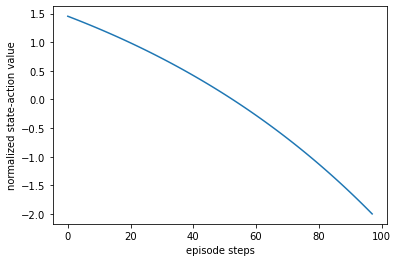

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

action 0
reward 1.0
start store_trans
action 0
reward 1.0
episode: 2   reward: 83
vt [ 1.44387104  1.42402532  1.40397915  1.38373049  1.36327729  1.3426175
  1.32174903  1.30066976  1.27937757  1.2578703   1.23614579  1.21420184
  1.19203624  1.16964674  1.14703109  1.12418699  1.10111214  1.07780422
  1.05426086  1.03047969  1.00645831  0.98219428  0.95768517  0.93292849
  0.90792174  0.8826624   0.85714791  0.8313757   0.80534316  0.77904767
  0.75248657  0.72565718  0.69855678  0.67118264  0.64353199  0.61560205
  0.58738998  0.55889294  0.53010806  0.50103241  0.47166308  0.44199708
  0.41203143  0.38176309  0.35118902  0.32030611  0.28911126  0.2576013
  0.22577307  0.19362333  0.16114886  0.12834635  0.09521251  0.06174399
  0.02793739 -0.00621068 -0.04070368 -0.0755451  -0.11073845 -0.14628729
 -0.18219521 -0.21846584 -0.25510283 -0.2921099  -0.32949077 -0.36724923
 -0.40538909 -0.4439142  -0.48282845 -0.52213577 -0.56184014 -0.60194556
 -0.64245609 -0.68337581 -0.72470887 -0.7

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
episode: 8   reward: 84
vt [ 1.54944609  1.50384076  1.45777477  1.41124347  1.36424215  1.31676608
  1.26881045  1.22037041  1.17144109  1.12201753  1.07209474  1.02166768
  0.97073125  0.91928032  0.86730968  0.81481408  0.76178823  0.70822676
  0.65412426  0.59947528  0.54427429  0.48851571  0.43219391  0.3753032
  0.31783784  0.25979203  0.20115989  0.14193551  0.0821129   0.02168602
 -0.03935122 -0.10100501 -0.16328156 -0.22618717 -0.28972819 -0.35391104
 -0.4187422  -0.48422822 -0.55037571 -0.61719136 -0.68468192 -0.7528542
 -0.82171508 -0.89127154 -0.96153058 -1.03249931 -1.10418489 -1.17659458
 -1.24973567 -1.32361556 -1.39824172 -1.47362167 -1.54976304 -1.62667351
 -1.70436086 -1.78283292 -1.86209763]
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_tr

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
episode: 13   reward: 83
vt [ 1.56649621e+00  1.51

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
episode: 25 

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
episode: 28   reward: 78
vt [ 1.53372539  1.49462445  1.45512854  1.41523369  1.37493586  1.33423097
  1.29311493  1.25158358  1.20963271  1.1672581   1.12445547  1.08122048
  1.03754878  0.99343595  0.94887753  0.90386903  0.8584059   0.81248354
  0.76609733  0.71924256  0.67191451  0.62410841  0.57581941  0.52704265
  0.47777319  0.42800606  0.37773623  0.32695862  0.27566811  0.22385952
  0.1715276   0.11866708  0.06527262  0.01133882 -0.04313977 -0.09816865
 -0.15375338 -0.20989956 -0.26661288 -0.32389906 -0.38176389 -0.44021322
 -0.4

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
episode: 30   reward: 78
vt [ 1.48684086  1.46016484  1.43321938  1.40600173  1.37850916  1.35073889
  1.32268811  1.29435399  1.26573367  1.23682425  1.20762282  1.17812642
  1.14833208  1.11823679  1.0878375   1.05713115  1.02611464  0.99478482
  0.96313855  0.93117261  0.89888379  0.86626882  0.8333244   0.80004721
  0.76643389  0.73248104  0.69818523  0.663543    0.62855085  0.59320524
  0.5575026   0.52143934  0.48501179  0.44821629  0.41104913  0.37350653
  0.33558472  0.29727985  0.25858807  0.21950547  0.18002809  0.14015195
  0.09987301  0.05918723  0.01809047 -0.02342141 -0.06535259 -0.10770733
 -0.15048989 -0.19370459 -0.23735581 -0.28144795 -0.32598547 -0.37097286
 -0.41641467 -0.46231548 -0.50867994 -0.55551273 -0.60281858 -0.65060226
 -0.69886861 -

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
episode: 32   reward: 79
vt [ 1.43910151e+00  1.41985847e+00  1.40042105e+00  1.38078729e+00
  1.36095522e+00  1.34092282e+00  1.32068807e+00  1.30024893e+00
  1.27960334e+00  1.25874920e+00  1.23768442e+00  1.21640686e+00
  1.19491437e+00  1.17320479e+00  1.15127592e+00  1.12912555e+00
  1.10675144e+00  1.08415132e+00  1.06132292e+00  1.03826393e+00
  1.01497203e+00  9.91444845e-01  9.67680017e-01  9.43675140e-01
  9.19427790e-01  8.94935517e-01  8.70195847e-01  8.45206282e-01
  8.19964296e-01  7.94467342e-01  7.68712842e-01  7.42698196e-01
  7.16420775e-01  6.89877926e-01  6.63066967e-01  6.35985191e-01
  6.08629861e-01  5.80998215e-01  5.53087462e-01  5.24894781e-01
  4.96417326e-01  

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

 -2.41055565 -2.44890664 -2.48764501 -2.52677469]
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0


start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
episode: 56   reward: 109
vt [ 1.07367799e+00  1.07124904e+00  1.06879557e+00  1.06631731e+00
  1.06381401e+00  1.06128543e+00  1.05873131e+00  1.05615140e+00
  1.05354542e+00  1.05091311e+00  1.04825422e+00  1.04556848e+00
  1.04285560e+00  1.04011532e+00  1.03734736e+00  1.03455144e+00
  1.03172728e+00  1.02887459e+00  1.02599309e+00  1.02308248e+00
  1.02014248e+00  1.01717277e+00  1.01417307e+00  1.01114307e+00
  1.00808246e+00  1.00499093e+00  1.00186818e+00  9.98713888e-01
  9.95527733e-01  9.92309393e-01  9.89058546e-01  9.85774862e-01
  9.82458009e-01  9.79107652e-01  9.75723454e-01  9.72305072e-01
  9.68852160e-01  9.65364371e-01  9.61841351e-01  9.58282746e-01
  9.54688195e-01  9.51057335e-01  9.47389800e-01  9.43685219e-01
  9.39943219e-01  9.36163420e-01  9.32345441e-01  9.28488897e-01
  9.24593398e-01  9.20658551e-01  9.16683957e-01  9.12669217e-01
  9.08613923e-01  9.04517667e-01  9.00380034e-01  8.96200607e-01
  8.91978964e-01  8.877

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
episode: 58   reward: 111
vt [ 1.25029046  1.24377403  1.23719178  1.23054304  1.22382714  1.2170434
  1.21019114  1.20326966  1.19627827  1.18921627  1.18208292  1.17487753
  1.16759935  1.16024765  1.1528217   1.14532073  1.137744    1.13009074
  1.12236017  1.11455151  1.10666398  1.09869678  1.0906491   1.08252013
  1.07430904  1.06601502  1.057637

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
episode: 63   reward: 115
vt [ 1.32267022  1.31298282  1.30319757  1.29331348  1.28332956  1.27324478
  1.26305814  1.2527686   1.24237513  1.23187667  1.22127217  1.21056055
  1.19974074  1.18881163  1.17777213  1.16662111  1.15535746  1.1

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_

action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
rew

start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_

start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 0
reward 1.0
start store_trans
action 1
reward 1.0
start store_trans
action 1
reward 1.0
start store_

In [7]:
for i_episode in range(70):  # 跑完一整个回合才更新一次

    observation = env.reset()  # 初始状态

    while True:
        if RENDER: env.render()

        action = RL.choose_action(observation)  # 根据状态选择动作
        
        # observation_:动作后，智能体观测到的环境的状态
        # reward: 由上一个动作产生的立即奖励值
        # done：一个指示位，表示这一训练周期是否结束，True or False
        # info：包含一些其余信息，结构是字典，调试项
        observation_, reward, done, info = env.step(action)
        print('start store_trans')
        RL.store_transition(observation, action, reward)
        print('action',action)
        print('reward',reward)
        if done:
            ep_rs_sum = sum(RL.ep_rs)

            if 'running_reward' not in globals():
                running_reward = ep_rs_sum
            else:
                running_reward = running_reward * 0.99 + ep_rs_sum * 0.01
            if running_reward > DISPLAY_REWARD_THRESHOLD: 
                RENDER = True     # rendering
            print("episode:", i_episode, "  reward:", int(running_reward))

            vt = RL.learn()
            print('vt',vt)
            if i_episode == 0:
                plt.plot(vt)    # plot the episode vt
                plt.xlabel('episode steps')
                plt.ylabel('normalized state-action value')
                plt.show()
            break

        observation = observation_